# Retail Analytics: Exploratory Data Analysis & Regression Modeling

## Executive Snapshot
- Goal: understand key drivers of retail performance and quantify relationships using interpretable regression models.
- Methods: univariate/bivariate/multivariate EDA, simple & multiple linear regression, polynomial regression, residual diagnostics.
- Outputs: reproducible notebook with clean visualizations, fitted models, and diagnostic checks suitable for a portfolio.

## Tech Stack
Python · pandas · numpy · matplotlib · seaborn · scikit-learn


In [ ]:
!mkdir -p data
!gdown https://drive.google.com/uc?id=1dxMJzvvdRnyG8IW-rbOkJvqPszrShB21 -O data/walmart.csv
!gdown https://drive.google.com/uc?id=1RkwAgMAPOg2WyZcbj1SJg531413qU_QP -O data/imdb.csv

Downloading...
From: https://drive.google.com/uc?id=1dxMJzvvdRnyG8IW-rbOkJvqPszrShB21
To: /content/data/walmart.csv
100% 364k/364k [00:00<00:00, 7.77MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RkwAgMAPOg2WyZcbj1SJg531413qU_QP
To: /content/data/imdb.csv
100% 438k/438k [00:00<00:00, 18.7MB/s]


## Data Sources
- [Walmart Dataset (Retail)](https://www.kaggle.com/datasets/rutuspatel/walmart-dataset-retail)
- [IMDB Dataset (Top 1000 Movies & TV Shows)](https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows)


In [ ]:
# Helper cell (portfolio-neutral).

%%capture
# !pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, HTML

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from statsmodels import api as sm
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
sns.set(style='whitegrid', context='talk')

In [ ]:
df = pd.read_csv('data/walmart.csv')
df.columns = df.columns.str.lower()
df.date = pd.to_datetime(df.date, format='%d-%m-%Y')
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
print(f'Shape: {df.shape}')
df.head()

Shape: (6435, 11)


,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,12
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,5


# Exploratory Data Analysis

## Univariate Analysis


In [ ]:
df.describe()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,day
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.447552,15.678322
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.000000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,8.000000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,16.000000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,23.000000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,31.000000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.238308,8.755780


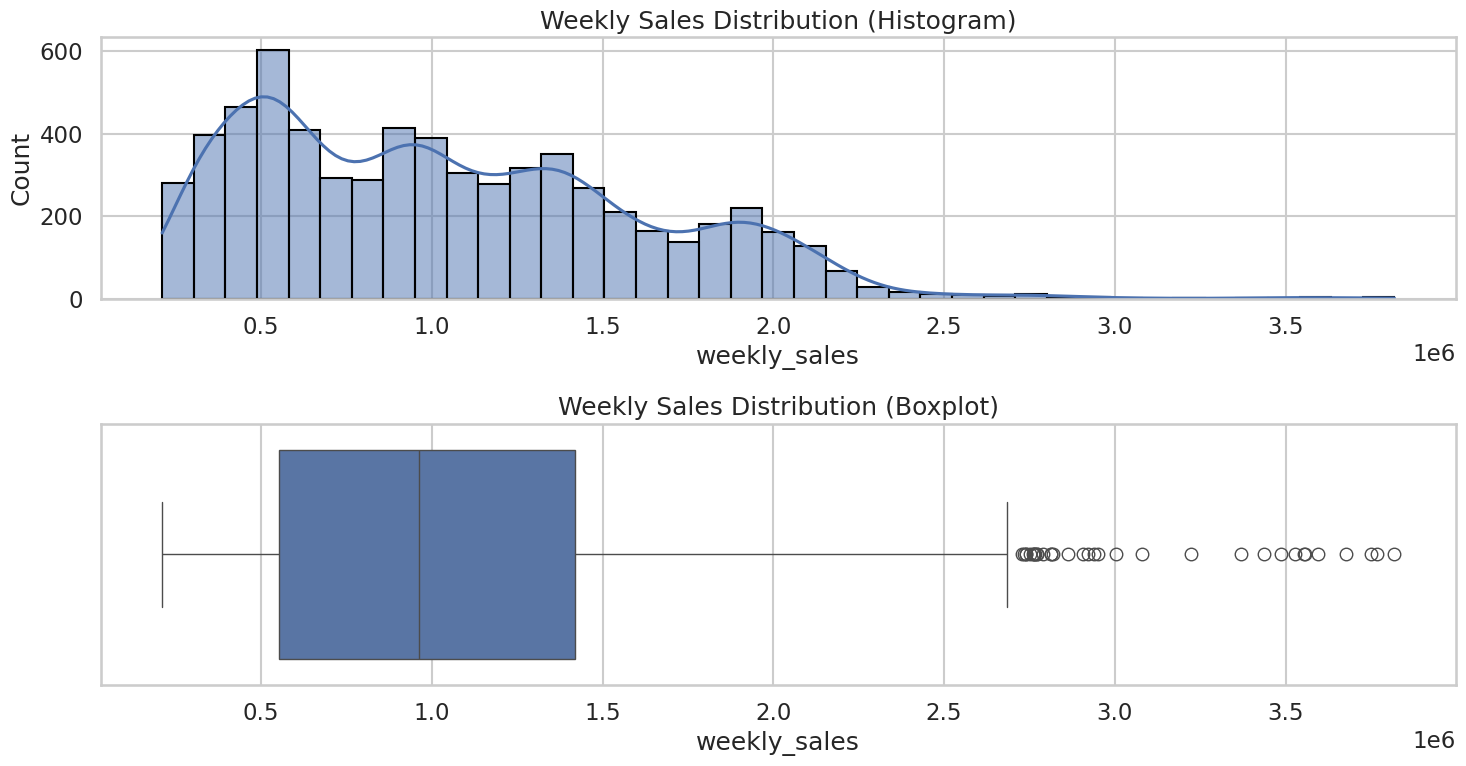

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.histplot(df['weekly_sales'], kde=True, ax=ax[0], edgecolor='black')
ax[0].set_title('Weekly Sales Distribution (Histogram)')
sns.boxplot(df['weekly_sales'], ax=ax[1], orient='h')
ax[1].set_title('Weekly Sales Distribution (Boxplot)')
fig.tight_layout()
plt.show()

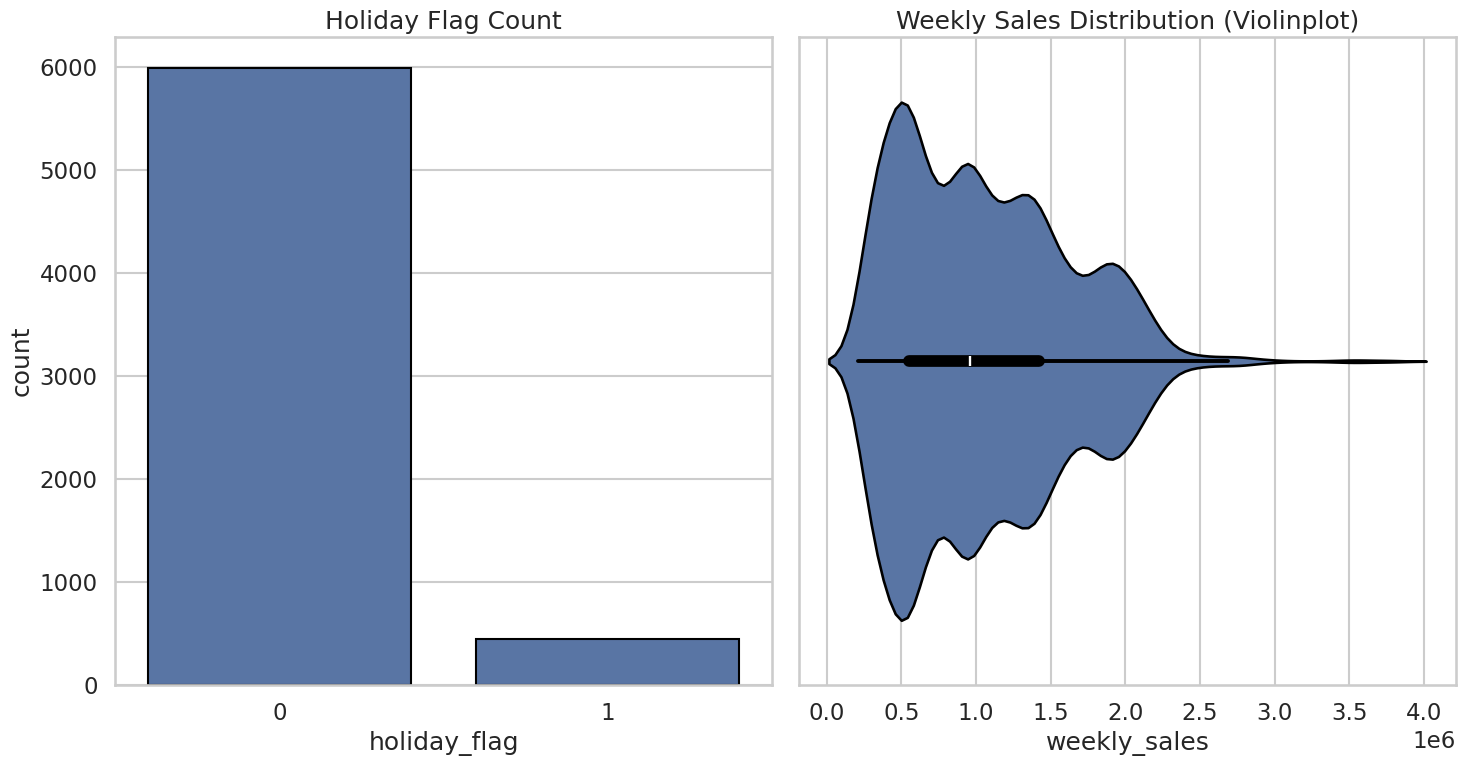

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x='holiday_flag', data=df, ax=ax[0], edgecolor='black')
ax[0].set_title('Holiday Flag Count')
sns.violinplot(x='weekly_sales', data=df, ax=ax[1], edgecolor='black')
ax[1].set_title('Weekly Sales Distribution (Violinplot)')
fig.tight_layout()
plt.show()

In [ ]:
imdb = pd.read_csv('data/imdb.csv')
imdb.columns = imdb.columns.str.lower().str.strip()
imdb.loc[966, 'released_year'] = 1995
imdb['released_year'] = imdb['released_year'].astype(int)
imdb.head(1)

,poster_link,series_title,released_year,certificate,runtime,genre,imdb_rating,overview,meta_score,director,star1,star2,star3,star4,no_of_votes,gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"


In [ ]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   poster_link    1000 non-null   object 
 1   series_title   1000 non-null   object 
 2   released_year  1000 non-null   int64  
 3   certificate    899 non-null    object 
 4   runtime        1000 non-null   object 
 5   genre          1000 non-null   object 
 6   imdb_rating    1000 non-null   float64
 7   overview       1000 non-null   object 
 8   meta_score     843 non-null    float64
 9   director       1000 non-null   object 
 10  star1          1000 non-null   object 
 11  star2          1000 non-null   object 
 12  star3          1000 non-null   object 
 13  star4          1000 non-null   object 
 14  no_of_votes    1000 non-null   int64  
 15  gross          831 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.1+ KB


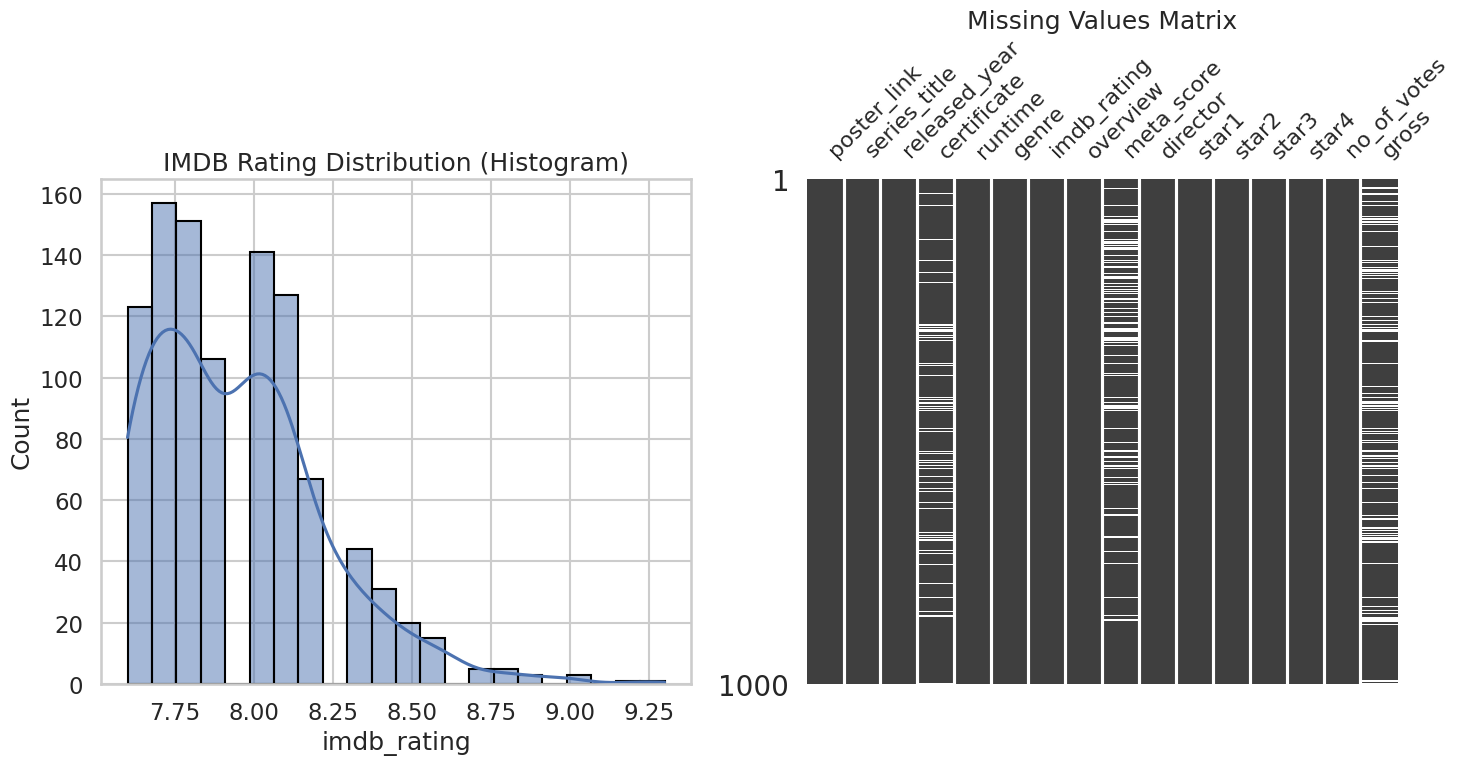

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.histplot(imdb['imdb_rating'], kde=True, ax=ax[0], edgecolor='black')
ax[0].set_title('IMDB Rating Distribution (Histogram)')
msno.matrix(imdb, ax=ax[1], sparkline=False)
ax[1].set_title('Missing Values Matrix')
fig.tight_layout()
plt.show()

## Bivariate Analysis

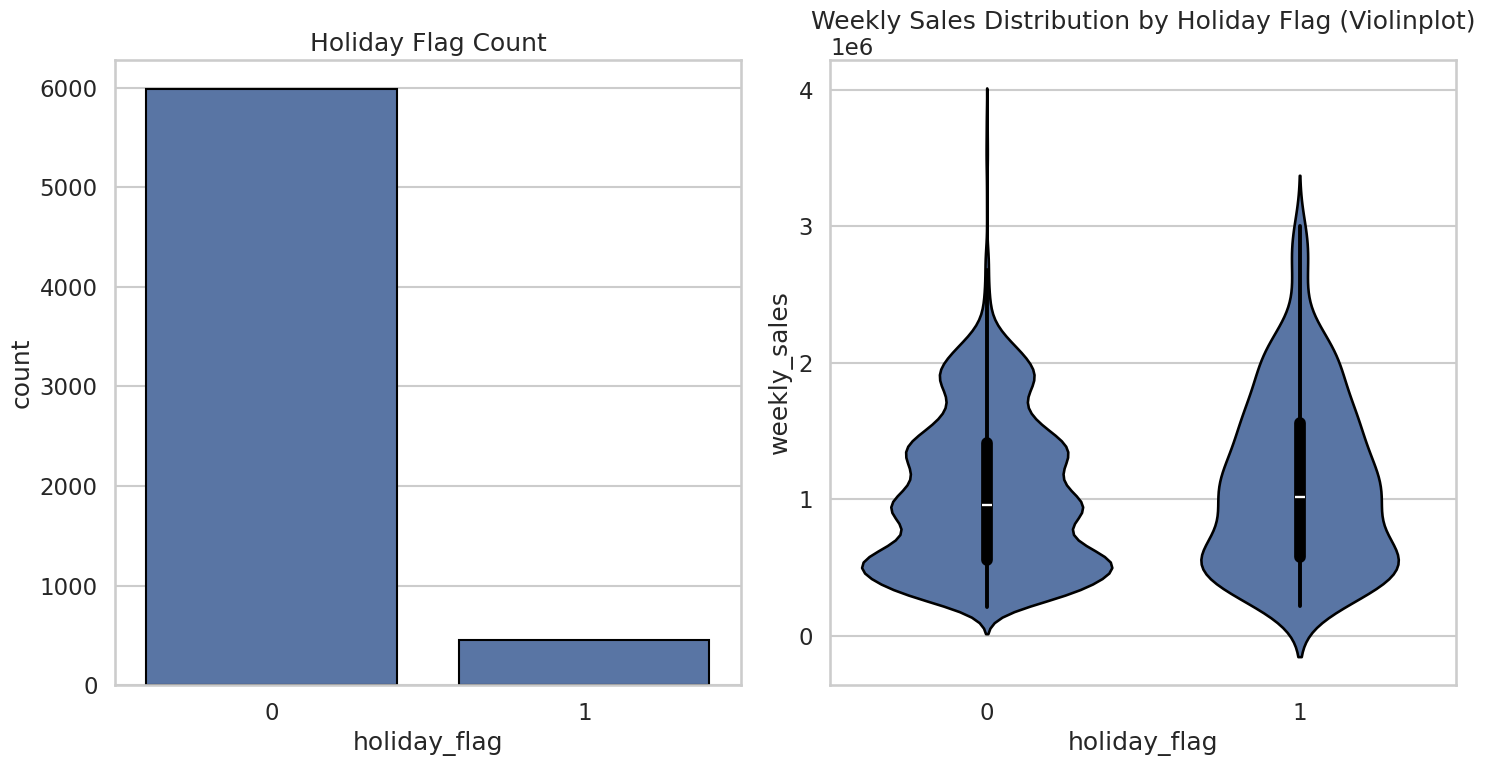

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x='holiday_flag', data=df, ax=ax[0], edgecolor='black')
ax[0].set_title('Holiday Flag Count')
sns.violinplot(x='holiday_flag', y='weekly_sales', data=df, ax=ax[1], edgecolor='black')
ax[1].set_title('Weekly Sales Distribution by Holiday Flag (Violinplot)')
fig.tight_layout()
plt.show()

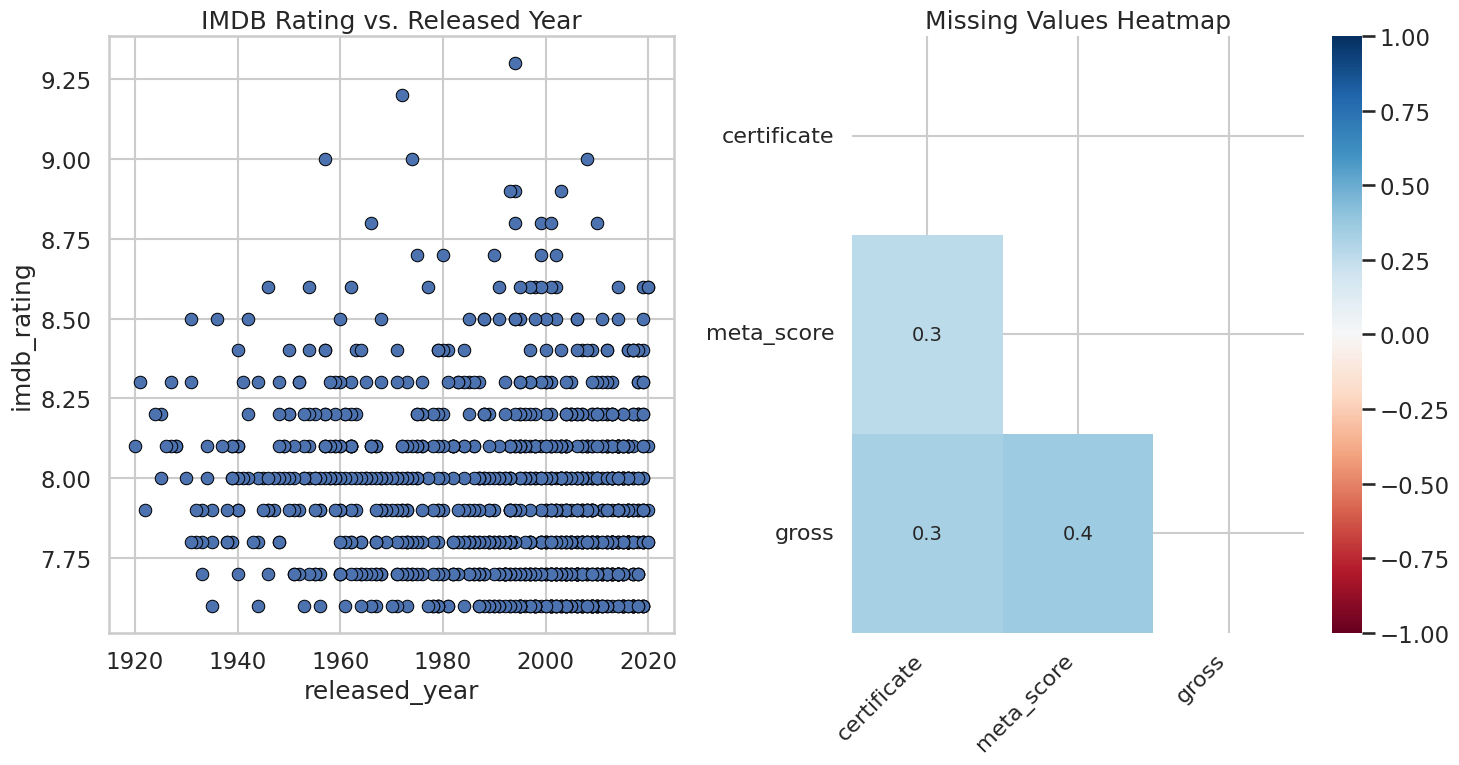

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.scatterplot(x='released_year', y='imdb_rating', data=imdb, ax=ax[0], edgecolor='black')
ax[0].set_title('IMDB Rating vs. Released Year')
msno.heatmap(imdb, ax=ax[1])
ax[1].set_title('Missing Values Heatmap')
fig.tight_layout()
plt.show()

## Multivariate Analysis

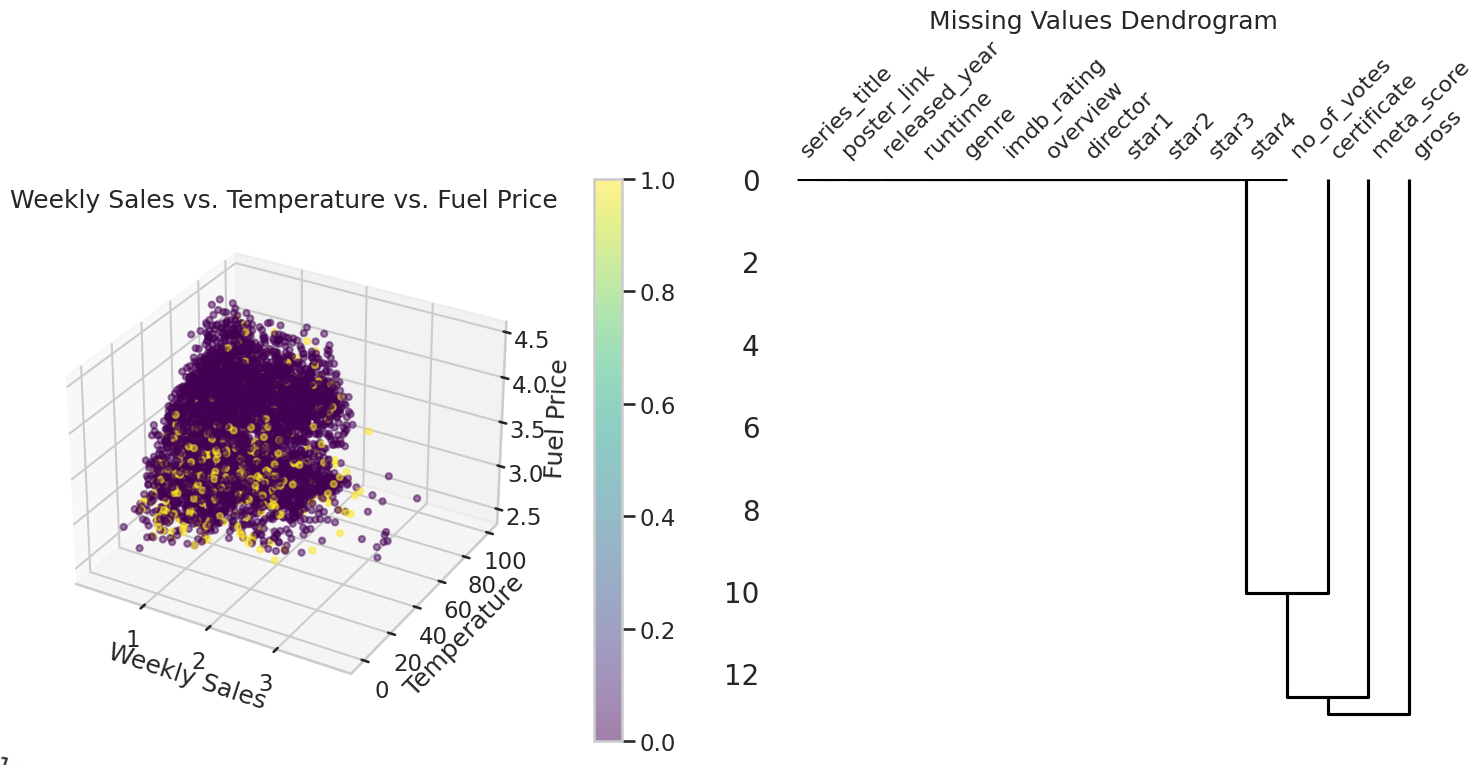

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)
scatter_3d = ax1.scatter(df['weekly_sales'], df['temperature'], df['fuel_price'], c=df['holiday_flag'], cmap='viridis', alpha=0.5)
ax1.set_xlabel('Weekly Sales')
ax1.set_ylabel('Temperature')
ax1.set_zlabel('Fuel Price')
ax1.set_title('Weekly Sales vs. Temperature vs. Fuel Price')
fig.colorbar(scatter_3d, ax=ax1, pad=0.1)
msno.dendrogram(imdb, ax=ax2)
ax2.set_title('Missing Values Dendrogram')
plt.tight_layout()
plt.show()

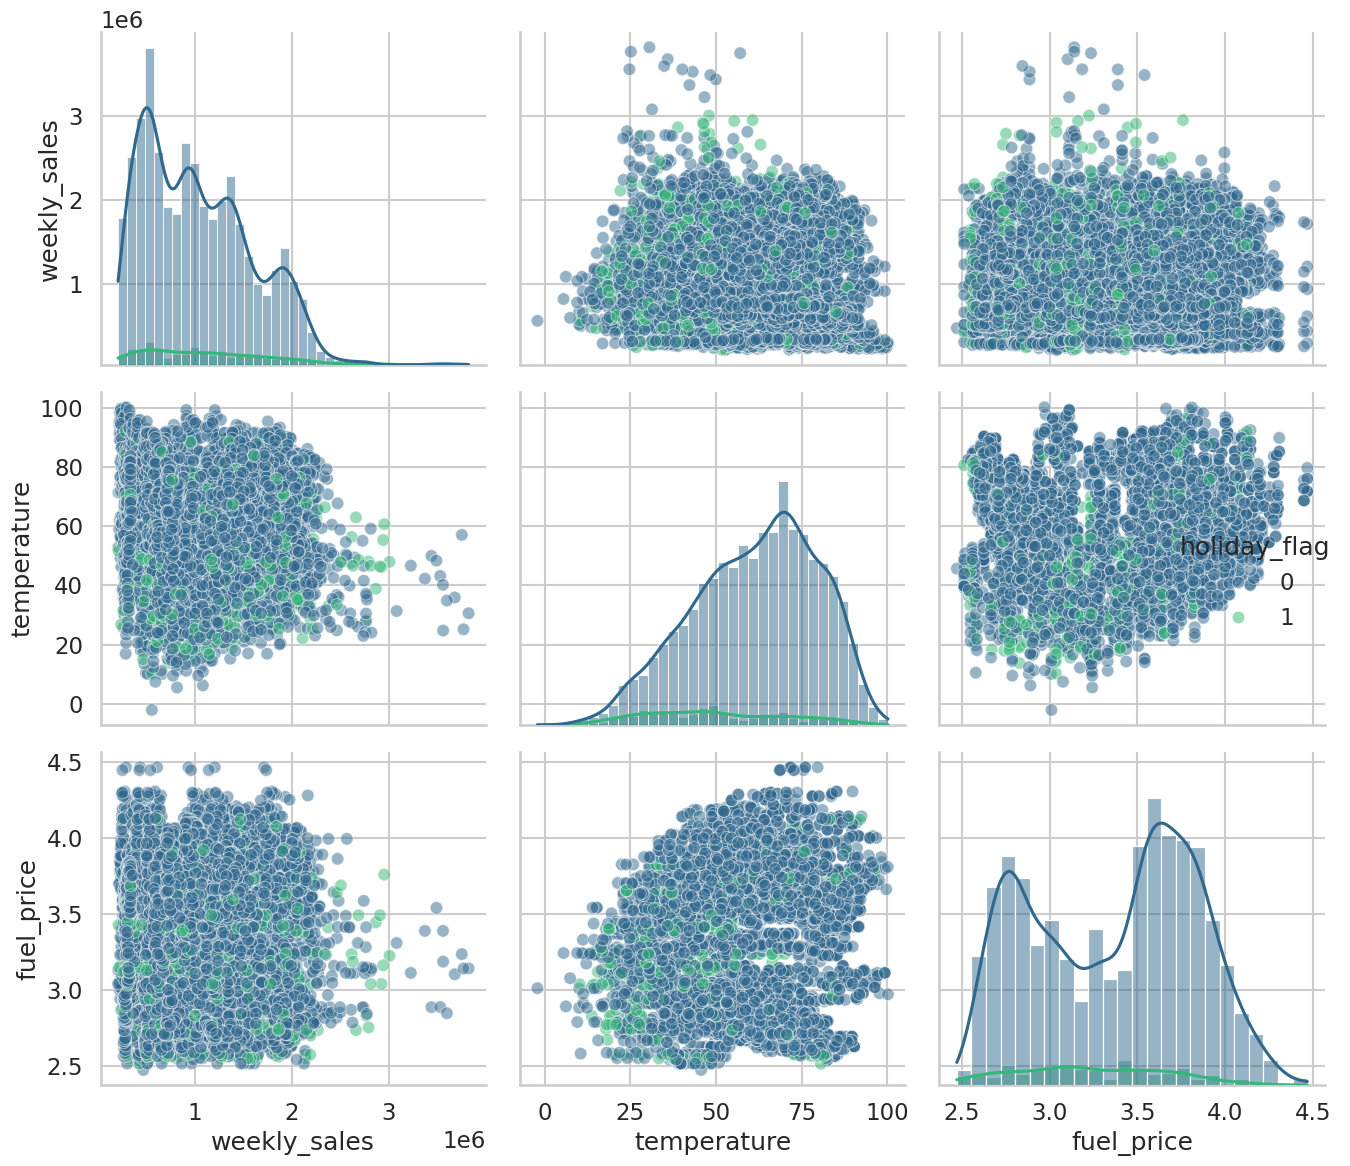

In [ ]:
grid = sns.PairGrid(df, vars=['weekly_sales', 'temperature', 'fuel_price'], hue='holiday_flag', palette='viridis', height=4)
grid.map_diag(sns.histplot, kde=True, alpha=0.5)
grid.map_offdiag(sns.scatterplot, alpha=0.5)
grid.add_legend()
plt.tight_layout()
plt.show()

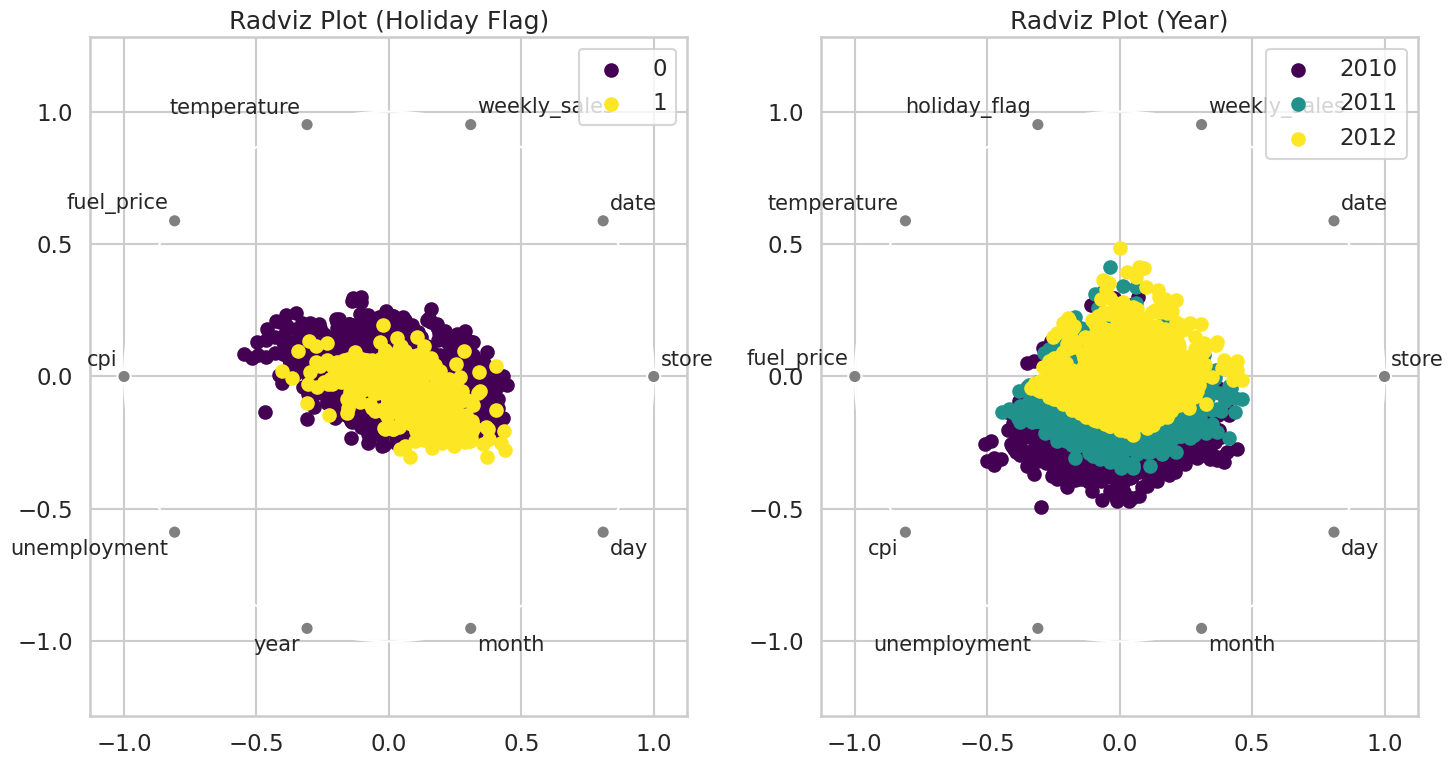

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
pd.plotting.radviz(df, 'holiday_flag', ax=ax[0], colormap='viridis')
ax[0].set_title('Radviz Plot (Holiday Flag)')
pd.plotting.radviz(df, 'year', ax=ax[1], colormap='viridis')
ax[1].set_title('Radviz Plot (Year)')
fig.tight_layout()

# Linear Regression

## Simple Regression

In [ ]:
x = df[['temperature', 'fuel_price', 'cpi', 'unemployment']]
y = df['weekly_sales']

In [ ]:
x_simple = x[['fuel_price']]
x_simple = sm.add_constant(x_simple)

simple_model = sm.OLS(y, x_simple).fit()
print(simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:           weekly_sales   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5762
Date:                Thu, 27 Jun 2024   Prob (F-statistic):              0.448
Time:                        20:28:21   Log-Likelihood:                -94352.
No. Observations:                6435   AIC:                         1.887e+05
Df Residuals:                    6433   BIC:                         1.887e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+06    5.2e+04     19.397      0.0

In [ ]:
simple_pred = simple_model.predict(x_simple)
simple_mse = mean_squared_error(y, simple_pred)
simple_mae = mean_absolute_error(y, simple_pred)
simple_rmse = np.sqrt(simple_mse)
print(f'Simple Regression Model:')
print(f'MSE: {simple_mse:.2f}')
print(f'MAE: {simple_mae:.2f}')
print(f'RMSE: {simple_rmse:.2f}')

Simple Regression Model:
MSE: 318431665304.05
MAE: 469015.11
RMSE: 564297.50


## Multiple Linear Regression

In [ ]:
x_multi = sm.add_constant(x)

multi_model = sm.OLS(y, x_multi).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           weekly_sales   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     40.09
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           3.21e-33
Time:                        20:28:29   Log-Likelihood:                -94273.
No. Observations:                6435   AIC:                         1.886e+05
Df Residuals:                    6430   BIC:                         1.886e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.744e+06   7.96e+04     21.918   

In [ ]:
multi_pred = multi_model.predict(x_multi)
multi_mse = mean_squared_error(y, multi_pred)
multi_mae = mean_absolute_error(y, multi_pred)
multi_rmse = np.sqrt(multi_mse)
print(f'Multiple Linear Regression Model:')
print(f'MSE: {multi_mse:.2f}')
print(f'MAE: {multi_mae:.2f}')
print(f'RMSE: {multi_rmse:.2f}')

Multiple Linear Regression Model:
MSE: 310711823081.11
MAE: 467733.84
RMSE: 557415.31


## Polynomial Regression

In [ ]:
poly = PolynomialFeatures(degree=6)
x_poly = poly.fit_transform(x[['cpi']])

poly_model = sm.OLS(y, x_poly).fit()
print(poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:           weekly_sales   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     16.97
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           7.50e-14
Time:                        22:57:44   Log-Likelihood:                -94318.
No. Observations:                6435   AIC:                         1.886e+05
Df Residuals:                    6430   BIC:                         1.887e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3525      0.247     -1.428      0.1

In [ ]:
poly_pred = poly_model.predict(x_poly)
poly_mse = mean_squared_error(y, poly_pred)
poly_mae = mean_absolute_error(y, poly_pred)
poly_rmse = np.sqrt(poly_mse)
print(f'Polynomial Regression Model:')
print(f'MSE: {poly_mse:.2f}')
print(f'MAE: {poly_mae:.2f}')
print(f'RMSE: {poly_rmse:.2f}')

Polynomial Regression Model:
MSE: 315133176466.46
MAE: 467524.53
RMSE: 561367.24


## Residuals

In [ ]:
simple_fitted = simple_model.fittedvalues
multi_fitted = multi_model.fittedvalues
poly_fitted = poly_model.fittedvalues

In [ ]:
simple_residuals = simple_model.resid
multi_residuals = multi_model.resid
poly_residuals = poly_model.resid

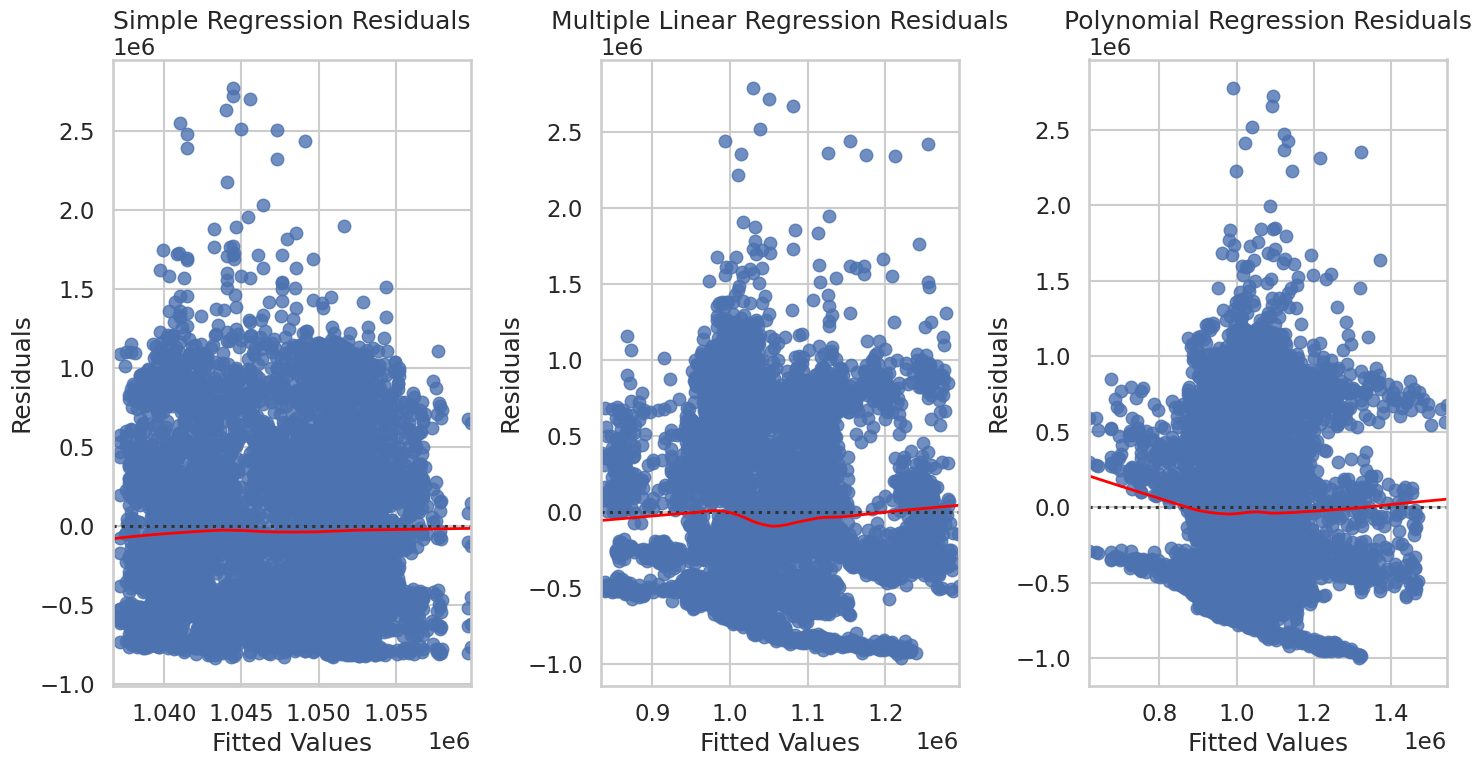

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))

sns.residplot(x=simple_fitted, y=simple_residuals, lowess=True, line_kws={'color': 'red', 'lw': 2}, ax=ax[0])
ax[0].set_title('Simple Regression Residuals')
ax[0].set_xlabel('Fitted Values')
ax[0].set_ylabel('Residuals')

sns.residplot(x=multi_fitted, y=multi_residuals, lowess=True, line_kws={'color': 'red', 'lw': 2}, ax=ax[1])
ax[1].set_title('Multiple Linear Regression Residuals')
ax[1].set_xlabel('Fitted Values')
ax[1].set_ylabel('Residuals')

sns.residplot(x=poly_fitted, y=poly_residuals, lowess=True, line_kws={'color': 'red', 'lw': 2}, ax=ax[2])
ax[2].set_title('Polynomial Regression Residuals')
ax[2].set_xlabel('Fitted Values')
ax[2].set_ylabel('Residuals')

fig.tight_layout()
plt.show()

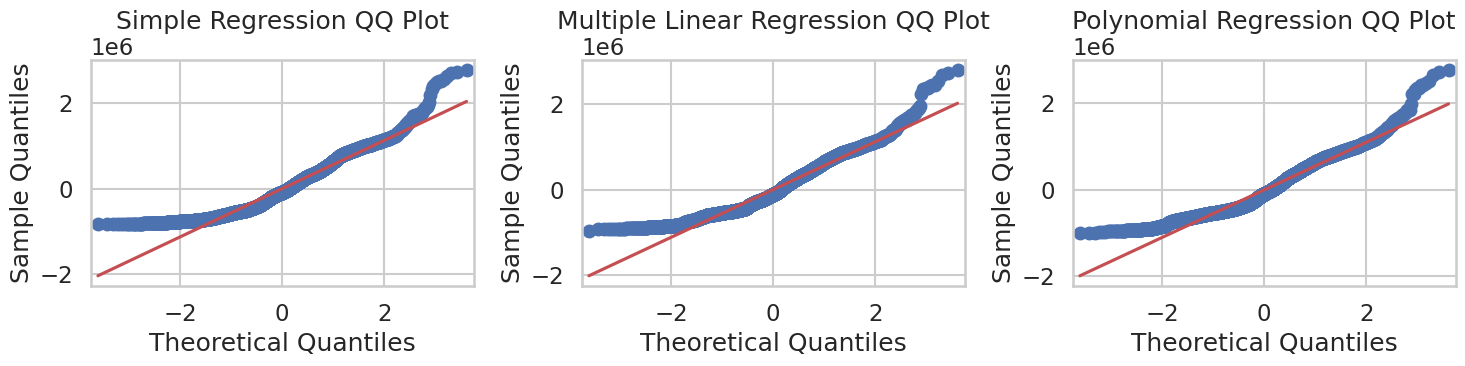

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sm.qqplot(simple_residuals, line='s', ax=ax[0])
ax[0].set_title('Simple Regression QQ Plot')
ax[0].set_xlabel('Theoretical Quantiles')
ax[0].set_ylabel('Sample Quantiles')

sm.qqplot(multi_residuals, line='s', ax=ax[1])
ax[1].set_title('Multiple Linear Regression QQ Plot')
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')

sm.qqplot(poly_residuals, line='s', ax=ax[2])
ax[2].set_title('Polynomial Regression QQ Plot')
ax[2].set_xlabel('Theoretical Quantiles')
ax[2].set_ylabel('Sample Quantiles')

fig.tight_layout()
plt.show()